<a href="https://colab.research.google.com/github/zhibinz2/Neural-Networks-and-Machine-Learning/blob/master/ZHIBIN_Final_Project_all_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Load files and datas **

**Load files**

load from GitHub

(Looks like this work. But the data imported is not indexable?)


https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy

AwakeSamples.npy contains 200 spectra samples of 91 by 91 matrices.

https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/SedatedSamples.npy

SedatedSamples.npy contains 200 spectra samples of 91 by 91 matrices.

https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/data.npy

data.npy contains 4000 sepctra samples. 

The first 200 samples are from AwakeSamples.npy

The second 200 samples are from SedatedSamples.npy

https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/targets.npy

targets.npy is a vector with 400 elements. 

The first 200 elements are 0

The second 200 elements are 1

In [146]:
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
AwakeSamples=np.load('AwakeSamples.npy')
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/SedatedSamples.npy
SedatedSamples=np.load('SedatedSamples.npy')


--2020-12-09 06:35:20--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/AwakeSamples.npy
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy [following]
--2020-12-09 06:35:20--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/AwakeSamples.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13249728 (13M) [application/octet-stream]
Saving to: ‘AwakeSamples.npy.7’

AwakeSamples.npy.7  100%[===================>]  12.64M  --.-KB/s    in 0.08s   

2020-12-09 06:35:20 (165 M

In [147]:
import tqdm

import torch
from torch import optim
from torch import nn


import torchvision
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from torchvision import models, transforms
from torch.autograd import Variable

import pandas as pd
from PIL import Image
import requests
import io
import random, time, sys
from collections import namedtuple

import matplotlib.pyplot as plt


**Loading data**

In [148]:
# Conbine two categories of samples into data
data=np.concatenate((AwakeSamples,SedatedSamples),axis=0)

In [149]:
# resize the data to 28 by 28 (only for convolutional network)
import cv2
# resize matrices into 28 by 28 (for convolutional network only)
resize=np.zeros([400,28,28])
for j in np.array(range(400)):
    img=data[j,:,:]
    dim = (28, 28)
    resize[j,:,:] = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
data=resize

In [150]:
# Add one dimension
data=np.expand_dims(data, axis=1)

In [151]:
idx1=20
idx2=380

In [152]:
train_data=data[idx1:idx2,:,:]
test_data=np.concatenate((data[0:idx1,:,:],data[idx2:400,:,:]),axis=0)

In [ ]:
# Create the targets (only for single layer FCN)
import numpy.matlib
A=numpy.matlib.repmat(np.array([1, 0]),200,1)
B=numpy.matlib.repmat(np.array([0, 1]),200,1)
targets=np.concatenate((A,B),axis=0)

In [153]:
# load the targets only for convolutional network
import numpy as np
!wget https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/targets.npy
targets=np.load('targets.npy')

--2020-12-09 06:35:46--  https://github.com/zhibinz2/Neural-Networks-and-Machine-Learning/raw/master/targets.npy
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/targets.npy [following]
--2020-12-09 06:35:46--  https://raw.githubusercontent.com/zhibinz2/Neural-Networks-and-Machine-Learning/master/targets.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3328 (3.2K) [application/octet-stream]
Saving to: ‘targets.npy.3’

targets.npy.3       100%[===================>]   3.25K  --.-KB/s    in 0s      

2020-12-09 06:35:46 (60.5 MB/s) - ‘targets.npy.3’

In [ ]:
# optional (examine step)
targets

In [ ]:
# update targets (only for single layer FCN)
train_targets=targets[idx1:idx2,:]
test_targets=np.concatenate((targets[0:idx1,:],targets[idx2:400,:]),axis=0)

In [154]:
# update targets (only for convolutional network)
train_targets=targets[idx1:idx2]
test_targets=np.concatenate((targets[0:idx1],targets[idx2:400]),axis=0)

In [155]:
from torch.utils.data import Dataset
class MyTrainingDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        self.root=root
        self.transform=transform
        self.target_transform=target_transform
        self.data=np.load(self.root[0])
        self.targets=np.load(self.root[1])
        
    def __len__(self):
        return len(self.data)
 
    def __getitem__(self, idx):
        sample=self.data[idx] 
        target=self.targets[idx]
        
        if self.transform:
            sample=self.transform(sample)
        if self.target_transform:
            target=self.target_transform(target)
            
        return sample, target

In [156]:
np.save('train_data.npy',train_data)
np.save('train_targets.npy',train_targets)
train_set=MyTrainingDataset(root=['train_data.npy', 'train_targets.npy'])

In [ ]:
# optional (examine step)
len(train_set[:][0])

In [ ]:
# optional (examine step)
import tensorflow as tf
tf.shape(train_set[0][0])

In [ ]:
# optional (examine step)
train_set[300][1]

In [157]:
np.save('test_data.npy',test_data)
np.save('test_targets.npy',test_targets)
test_set=MyTrainingDataset(root=['test_data.npy', 'test_targets.npy'])

In [ ]:
# optional (examine step)
test_set[0]

In [ ]:
# optional (examine step)
len(test_set)

**Train_loader and test_loader**

In [158]:
batch=40
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False)

In [ ]:
# optional (examine step)
len(train_loader)

# **4_fcn_anatomy**

**4_fcn_anatomy**

In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(8281, 300),
                          torch.nn.Tanh(), #this is an activation function
                          torch.nn.Linear(300, 300),
                          torch.nn.Tanh(), #this is an activation function
                          torch.nn.Linear(300, 2),                        
                          torch.nn.Sigmoid()).cuda()

In [ ]:
mse_loss = torch.nn.MSELoss().cuda()
opt = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-3)

In [ ]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [ ]:
x,t = next(iter(train_loader))

In [ ]:
x[0]

tensor([[[1.9703e-33, 6.1130e-34, 1.5980e-34,  ..., 1.5826e-33,
          4.9029e-34, 1.3977e-35],
         [9.2005e-03, 1.2034e-02, 3.5918e-03,  ..., 3.2607e-02,
          1.1214e-02, 4.5306e-03],
         [2.9027e-02, 4.6947e-02, 3.4890e-03,  ..., 3.6851e-02,
          3.3740e-02, 1.2015e-02],
         ...,
         [6.4051e-05, 2.2676e-05, 1.6426e-05,  ..., 6.9562e-05,
          1.4699e-05, 1.4126e-05],
         [1.6632e-05, 9.4002e-07, 9.5118e-06,  ..., 1.2645e-04,
          7.3324e-06, 5.1372e-06],
         [8.6917e-05, 3.4734e-05, 1.2924e-05,  ..., 3.4851e-05,
          1.7198e-05, 1.0359e-07]]], dtype=torch.float64)

In [ ]:
t[0]

tensor([1, 0])

In [ ]:
loss_ = train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)

In [ ]:
# Make prediction
x,t = next(iter(test_loader))   

In [ ]:
y = net(x.float().view(-1,8281).cuda())

In [ ]:
y

tensor([[0.5640, 0.4429]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
torch.argmax(y)

tensor(4, device='cuda:0')

In [ ]:
torch.argmax(t)

tensor(0)

In [ ]:
y.argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
torch.argmax(y,1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
# Calculate accuracy
t.argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
torch.mean((t.cuda().argmax(1) == y.cuda().argmax(1)).float())

tensor(1., device='cuda:0')

In [ ]:
# Train the network over multiple epochs
SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler
subset_loader = torch.utils.data.DataLoader(train_set, batch_size=50, sampler=SubsetRandomSampler(range(200)))

train_accuracy = [] 
test_accuracy = [] 
for epoch in range(200):
    net.train() #training mode
    for x,t in iter(subset_loader):   
        loss_ = train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)

    acc_batch = []
    for x,t in iter(subset_loader):   
        y = net(x.float().view(-1,8281).cuda())
        batch_accuracy = torch.mean((t.float().argmax(1).cuda() == y.argmax(1).cuda()).float())
        acc_batch.append(batch_accuracy)
    train_accuracy.append(torch.mean(torch.FloatTensor(acc_batch)))
    
    acc_batch = []
    net.eval() #evaluation mode
    for x,t in iter(test_loader):   
        y = net(x.float().view(-1,8281).cuda())
        batch_accuracy = torch.mean((t.argmax(1).cuda() == y.argmax(1).cuda()).float())
        acc_batch.append(batch_accuracy)
    test_accuracy.append(torch.mean(torch.FloatTensor(acc_batch)))
    print('Accuracy:', torch.mean(torch.FloatTensor(acc_batch)))


Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.5000)
Accuracy: tensor(0.4000)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3250)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3500)
Accuracy: tensor(0.3750)
Accuracy: tensor(0.3500)


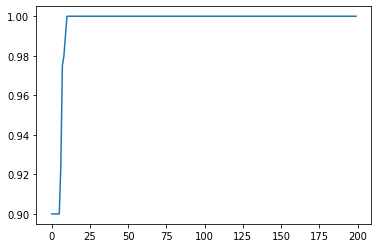

In [ ]:
plt.plot(train_accuracy)

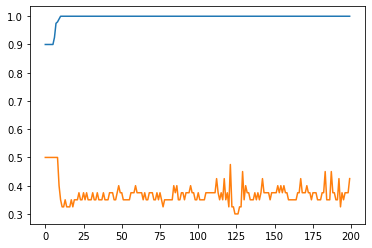

In [ ]:
plt.plot(train_accuracy)
plt.plot(test_accuracy)

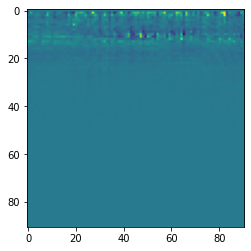

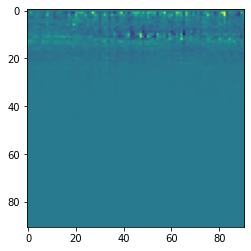

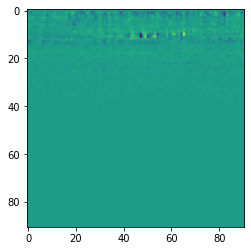

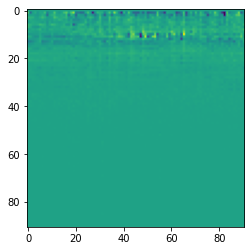

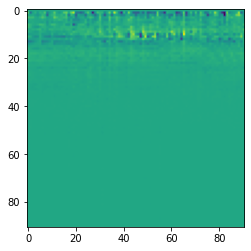

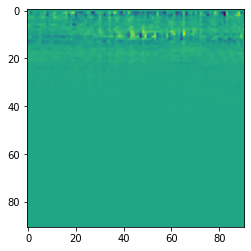

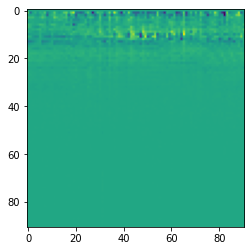

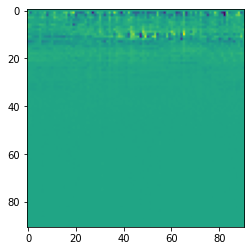

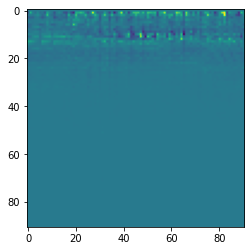

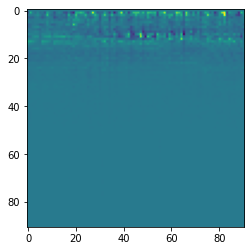

In [ ]:
net[0]

import pylab
for i in range(10):
    pylab.figure();
    pylab.imshow(net[0].cpu().weight.data[i].view(91,91))

# 4_fcn_single_layer

**4_fcn_single_layer**

In [ ]:
net = torch.nn.Sequential(torch.nn.Linear(8281, 100),torch.nn.Sigmoid(),torch.nn.Linear(100,2),
                                  torch.nn.Sigmoid())

In [ ]:
mse_loss = torch.nn.MSELoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x)
    loss = loss_fn(y, t)
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [ ]:
x,t = next(iter(train_loader))

In [ ]:
len(x)

40

In [ ]:
train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)

tensor(0.2612, grad_fn=<MseLossBackward>)

In [ ]:
# Make prediction
for x,t in iter(train_loader):
  y = net(x.float().view(-1,8281))

In [ ]:
len(y)

20

In [ ]:
y.detach().numpy()

array([[0.56248146, 0.46254086],
       [0.5662643 , 0.46396533],
       [0.55715925, 0.46585757],
       [0.5635618 , 0.4546597 ],
       [0.5624348 , 0.46599588],
       [0.56643593, 0.46166742],
       [0.54800445, 0.47705466],
       [0.55834615, 0.4662949 ],
       [0.5625649 , 0.46474284],
       [0.5545219 , 0.47163758],
       [0.56645185, 0.46390882],
       [0.5657375 , 0.46451667],
       [0.5620451 , 0.46682963],
       [0.55097586, 0.47299808],
       [0.55349034, 0.47145233],
       [0.5601283 , 0.46622404],
       [0.5595576 , 0.46484253],
       [0.55489385, 0.46836346],
       [0.5485895 , 0.47411373],
       [0.56099015, 0.4634188 ],
       [0.5511641 , 0.47293505],
       [0.56348884, 0.46304712],
       [0.55540466, 0.4649609 ],
       [0.5587225 , 0.46880138],
       [0.5419383 , 0.4790525 ],
       [0.56639117, 0.45411104],
       [0.539731  , 0.48213327],
       [0.55782056, 0.46904692],
       [0.5605655 , 0.46753132],
       [0.5625566 , 0.46666503],
       [0.

In [ ]:
y.argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
t.float()

tensor([[1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]])

In [ ]:
# Calculate accuracy
torch.mean((t.argmax(1) == y.argmax(1)).float())

tensor(0.4000)

In [ ]:
# Train the network over multiple epochs
acc_hist_train = []
acc_hist_test = []
for epoch in range(200):
    acc_batch = []
    for x,t in iter(train_loader):   
        loss_ = train_step(x.float().view(-1,8281), t.float(), net, opt, mse_loss)
        y = net(x.float().view(-1,8281))
        acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_)

    acc_batch = []
    for x,t in iter(test_loader):   
        y = net(x.float().view(-1,8281))
        acc_batch.append(torch.mean((t.argmax(1) == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))  

tensor(0.0155, grad_fn=<MseLossBackward>)
tensor(0.0171, grad_fn=<MseLossBackward>)
tensor(0.0145, grad_fn=<MseLossBackward>)
tensor(0.0132, grad_fn=<MseLossBackward>)
tensor(0.0134, grad_fn=<MseLossBackward>)
tensor(0.0183, grad_fn=<MseLossBackward>)
tensor(0.0112, grad_fn=<MseLossBackward>)
tensor(0.0144, grad_fn=<MseLossBackward>)
tensor(0.0100, grad_fn=<MseLossBackward>)
tensor(0.0148, grad_fn=<MseLossBackward>)
tensor(0.0120, grad_fn=<MseLossBackward>)
tensor(0.0185, grad_fn=<MseLossBackward>)
tensor(0.0131, grad_fn=<MseLossBackward>)
tensor(0.0116, grad_fn=<MseLossBackward>)
tensor(0.0130, grad_fn=<MseLossBackward>)
tensor(0.0049, grad_fn=<MseLossBackward>)
tensor(0.0062, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0143, grad_fn=<MseLossBackward>)
tensor(0.0093, grad_fn=<MseLossBackward>)
tensor(0.0066, grad_fn=<MseLossBackward>)
tensor(0.0063, grad_fn=<MseLossBackward>)
tensor(0.0065, grad_fn=<MseLossBackward>)
tensor(0.0071, grad_fn=<MseLossBac

In [ ]:
acc_hist_train

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),

In [ ]:
acc_hist_test

[tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.6750),
 tensor(0.6750),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000),
 tensor(0.7000

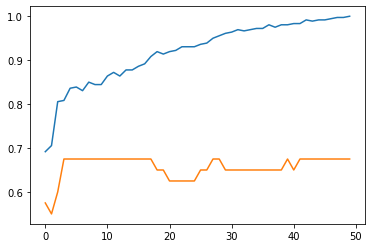

In [ ]:
from matplotlib import pyplot as plt
plt.plot(acc_hist_train)
plt.plot(acc_hist_test)

In [ ]:
net[0]

Linear(in_features=8281, out_features=100, bias=True)

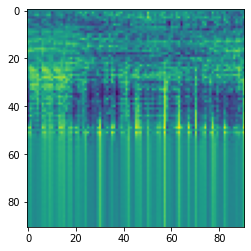

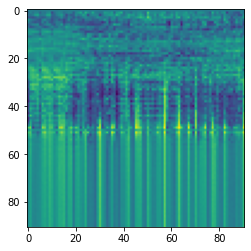

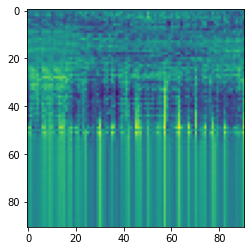

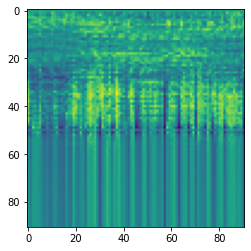

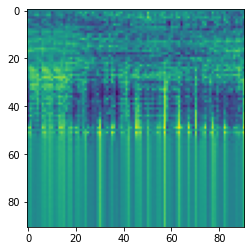

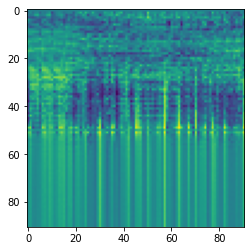

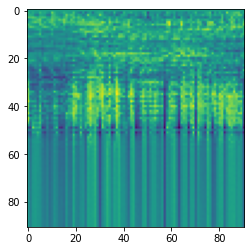

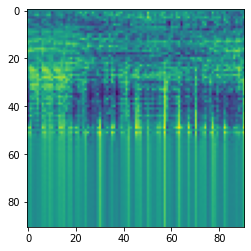

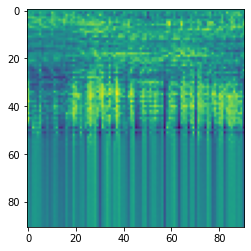

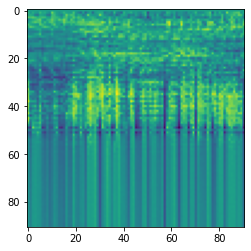

In [ ]:
import pylab
for i in range(10):
    pylab.figure();
    pylab.imshow(net[0].weight.data[i].view(91,91))

# **7_cnn_mnist.ipynb**

**7_cnn_mnist.ipynb**

In [ ]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, 1)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = torch.nn.Dropout2d(0.25)
        self.dropout2 = torch.nn.Dropout2d(0.5)
        self.pool2 = torch.nn.MaxPool2d((2,2),(2,2))
        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

net = LeNet().cuda()

In [ ]:
mse_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [ ]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [ ]:
x,t = next(iter(train_loader))

In [ ]:
# optional (examine step)
import tensorflow as tf
tf.shape(t)

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([40], dtype=int32)>

In [ ]:
train_step(x.float().cuda(), t.long().cuda(), net, opt, mse_loss)

tensor(0.7019, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
# Make prediction
for x,t in iter(test_loader):   
    y = net(x.float().cuda()).cpu()

In [ ]:
y.argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# Calculate accuracy
torch.mean((t == y.argmax(1)).float())

tensor(0.5000)

In [ ]:
# Train the network over multiple epochs
acc_hist_train = []
acc_hist_test = []
for epoch in range(20):
    acc_batch = []
    for x,t in iter(train_loader):   
        loss_ = train_step(x.float(), t.long(), net, opt, mse_loss)
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_)

    acc_batch = []
    for x,t in iter(test_loader):   
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch)))  

tensor(0.6595, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6678, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6377, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6230, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5521, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4570, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4910, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5054, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5076, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3441, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4133, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3882, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6286, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.4618, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3731, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.5309, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.3964, device='cuda:0', grad_fn=<NllLossBackward

In [ ]:
acc_hist_train

[tensor(0.6000),
 tensor(0.5917),
 tensor(0.6306),
 tensor(0.6361),
 tensor(0.7389),
 tensor(0.7389),
 tensor(0.7083),
 tensor(0.7972),
 tensor(0.7972),
 tensor(0.8278),
 tensor(0.8000),
 tensor(0.7750),
 tensor(0.8250),
 tensor(0.8306),
 tensor(0.8000),
 tensor(0.8222),
 tensor(0.8028),
 tensor(0.8278),
 tensor(0.8389),
 tensor(0.8528)]

In [ ]:
acc_hist_test

[tensor(0.6250),
 tensor(0.5750),
 tensor(0.5750),
 tensor(0.6500),
 tensor(0.6000),
 tensor(0.5750),
 tensor(0.5750),
 tensor(0.6000),
 tensor(0.6250),
 tensor(0.6250),
 tensor(0.6750),
 tensor(0.5250),
 tensor(0.6250),
 tensor(0.6000),
 tensor(0.6000),
 tensor(0.6750),
 tensor(0.5500),
 tensor(0.5250),
 tensor(0.6500),
 tensor(0.6250)]

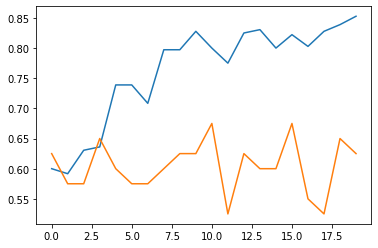

In [ ]:
import pylab as plt
plt.plot(range(len(acc_hist_train)), acc_hist_train)
plt.plot(range(len(acc_hist_test)), acc_hist_test)

In [ ]:
# We can plot the kernels learned by the CNN
net.conv1 #This is the first convolutional layer

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))

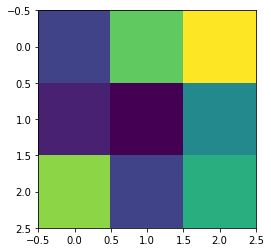

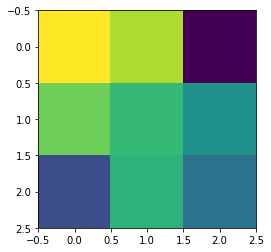

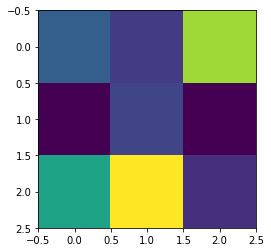

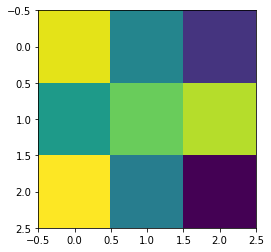

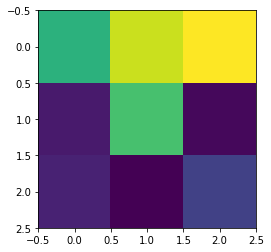

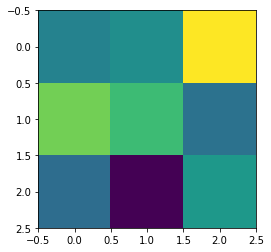

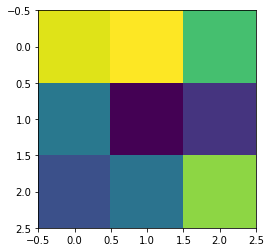

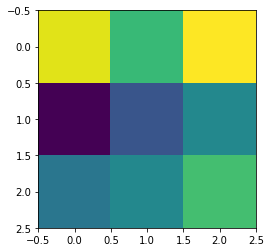

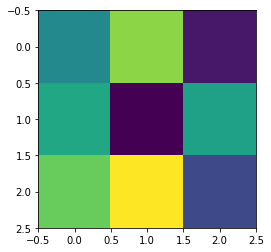

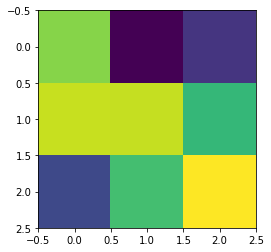

In [ ]:
import pylab
for i in range(10):
    pylab.figure();
    pylab.imshow(net.conv1.weight.data[i].cpu().detach().view(3,3))

# 8_nin_nist

**8_nin_nist**

In [159]:
class NIN(torch.nn.Module):
    def __init__(self):
        super(NIN, self).__init__()

        self.nin1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, 5, padding=2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, stride=2),
            torch.nn.Dropout(.5)          
        )
        self.nin2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(3, stride=2),
            torch.nn.Dropout(.5)          
        )
        self.nin3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, 1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 2, 1),
            torch.nn.ReLU(),
        )
        self.pool = torch.nn.AvgPool2d(6, stride=1)  


    def forward(self, x):
        x = self.nin1(x)
        x = self.nin2(x)
        x = self.nin3(x)
        x = self.pool(x)
        return x.view(-1,2)

net = NIN().cuda()

In [160]:
data, targets = next(iter(train_loader))

In [161]:
net(data.float().cuda()).shape

torch.Size([40, 2])

In [162]:
mse_loss = torch.nn.CrossEntropyLoss()
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

In [163]:
def train_step(x, t, net, opt_fn, loss_fn):
    y = net(x.cuda())
    loss = loss_fn(y, t.cuda())
    loss.backward()
    opt_fn.step()
    opt_fn.zero_grad()
    return loss

In [164]:
x,t = next(iter(train_loader))

In [165]:
train_step(x.float(), t.long(), net, opt, mse_loss)

tensor(0.6873, device='cuda:0', grad_fn=<NllLossBackward>)

In [166]:
# Train the network over multiple epochs
acc_hist_train = []
acc_hist_test = []
for epoch in range(20):
    acc_batch = []
    net.train()
    for x,t in iter(train_loader):   
        loss_train = train_step(x.float(), t.long(), net, opt, mse_loss)
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_train.append(torch.mean(torch.FloatTensor(acc_batch)))   
    print(loss_train)

    net.eval()
    acc_batch = []
    for x,t in iter(test_loader):   
        y = net(x.float().cuda()).cpu()
        acc_batch.append(torch.mean((t == y.argmax(1)).float()))
    acc_hist_test.append(torch.mean(torch.FloatTensor(acc_batch))) 


tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6922, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6933, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6960, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6917, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6930, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6935, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6932, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0.6931, device='cuda:0', grad_fn=<NllLossBackward

In [167]:
acc_hist_train

[tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5111),
 tensor(0.4944),
 tensor(0.5139),
 tensor(0.5194),
 tensor(0.4889),
 tensor(0.5111),
 tensor(0.4778),
 tensor(0.5028)]

In [168]:
acc_hist_test

[tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000)]

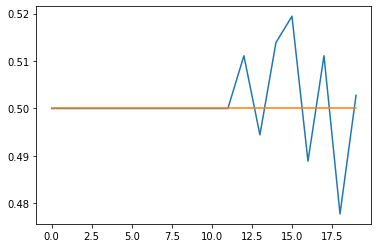

In [169]:
import pylab as plt
plt.plot(range(len(acc_hist_train)), acc_hist_train)
plt.plot(range(len(acc_hist_test)), acc_hist_test)

# Leave One Out Cross Validation

**Leave One Out Cross Validation**

In [ ]:
for train_index, test_index in loo.split(data):
  #print("TRAIN:", train_index, "TEST:", test_index)
  train_data, test_data = data[train_index], data[test_index]
  train_targets, test_targets = targets[train_index], targets[test_index]
  #print(train_data, test_data, train_targets, test_targets)

  np.save('train_data.npy',train_data)
  np.save('train_targets.npy',train_targets)
  train_set=MyTrainingDataset(root=['train_data.npy', 'train_targets.npy'])

  np.save('test_data.npy',test_data)
  np.save('test_targets.npy',test_targets)
  test_set=MyTrainingDataset(root=['test_data.npy', 'test_targets.npy'])

  batch=1
  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch, shuffle=False)